### 데이터 불러오기

In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
loan_data = pd.read_csv('/content/gdrive/MyDrive/loanData.csv')
loan_data.head()

,id,gender,age,married,dependents,education,self_employed,business_type,applicant_income,applicant_work_period,coapplicant_income,credit_history,credit_amount,property_area,property_type,credit_rate,loan_amount,loan_term,loan_status
0,LA001250,Male,55,Yes,3+,Not Graduate,No,88,4755,51,0.0,0.0,0,Semiurban,3,8,2090,0,0
1,LA001864,Male,68,Yes,3+,Not Graduate,No,14,4931,47,0.0,NaN,0,Semiurban,3,7,5376,24,0
2,LA002536,Male,43,Yes,3+,Not Graduate,No,56,3095,33,0.0,1.0,1382,Rural,3,5,3390,33,1
3,LA001264,Male,22,Yes,3+,Not Graduate,Yes,46,3333,68,2166.0,NaN,0,Semiurban,2,5,2600,36,1
4,LA001384,Male,34,Yes,3+,Not Graduate,No,60,2071,60,754.0,1.0,2756,Semiurban,2,5,2820,53,0


성별(gender), 부양가족(dependents), 학력(education) => 문자열

In [7]:
loan_data['gender'].unique()

array(['Male', 'Female', nan], dtype=object)

In [8]:
loan_data['married'].unique()

array(['Yes', 'No', nan], dtype=object)

In [6]:
loan_data['dependents'].unique()

array(['3+', '2', '1', '0', nan], dtype=object)

In [9]:
loan_data['education'].unique()

array(['Not Graduate', 'Graduate'], dtype=object)

In [10]:
loan_data['self_employed'].unique()

array(['No', 'Yes', nan], dtype=object)

In [11]:
loan_data['business_type'].unique()

array([88, 14, 56, 46, 60, 80, 21, 66, 30, 64, 42, 94,  4, 45, 26, 76, 74,
       35, 43, 59, 11, 29, 61, 78, 51, 81, 58, 10, 37, 16, 49, 55, 96, 36,
       83, 68, 70, 63, 13, 65, 86, 85, 40, 73, 41, 31, 24, 93, 27, 15, 97,
       82, 47,  3, 87, 53, 91, 48, 71, 84, 89, 33, 67, 57, 52, 90,  5,  1,
        2, 28, 77, 79, 92, 72, 99, 17, 44, 69, 95, 38, 20, 54, 34,  9,  8,
       50, 18,  6, 19, 62, 23, 32, 75, 98, 12, 22, 25,  7])

In [12]:
loan_data['credit_history'].unique()

array([ 0., nan,  1.])

In [13]:
loan_data['property_area'].unique()

array(['Semiurban', 'Rural', 'Urban'], dtype=object)

In [14]:
gendr_mapping = {'Male': 1, 'Female': 0, np.nan: -1}
married_mapping = {'No': 0, 'Yes': 1, np.nan: -1}
dep_mapping = {'0': 0, '1': 1, '2': 2, '3+': 3, np.nan: -1}
edu_mappiong = {'Graduate': 1, 'Not Graduate': 0}
emp_mapping = {'No': 0, 'Yes': 1, np.nan: -1}
prop_mapping = {'Urban': 1, 'Rural': 3, 'Semiurban': 2}

loan_data = loan_data.replace({'gender': gendr_mapping,
                               'married': married_mapping,
                               'dependents': dep_mapping,
                               'education': edu_mappiong,
                               'self_employed': emp_mapping,
                               'property_area': prop_mapping
                              })

In [15]:
loan_data.head()

,id,gender,age,married,dependents,education,self_employed,business_type,applicant_income,applicant_work_period,coapplicant_income,credit_history,credit_amount,property_area,property_type,credit_rate,loan_amount,loan_term,loan_status
0,LA001250,1,55,1,3,0,0,88,4755,51,0.0,0.0,0,2,3,8,2090,0,0
1,LA001864,1,68,1,3,0,0,14,4931,47,0.0,NaN,0,2,3,7,5376,24,0
2,LA002536,1,43,1,3,0,0,56,3095,33,0.0,1.0,1382,3,3,5,3390,33,1
3,LA001264,1,22,1,3,0,1,46,3333,68,2166.0,NaN,0,2,2,5,2600,36,1
4,LA001384,1,34,1,3,0,0,60,2071,60,754.0,1.0,2756,2,2,5,2820,53,0


In [16]:
X = loan_data.loc[:, 'gender':'loan_term']
y = loan_data.loc[:, 'loan_status']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

### 데이터 학습하기

In [22]:
model = XGBClassifier(
    booster = 'gbtree',
    objective='binary:logistic'
)
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [25]:
from sklearn.metrics import accuracy_score

def calculate_accuracy(model, x_test, y_test):
    # make predictions
    y_pred = model.predict(x_test)
    predictions = [round(value) for value in y_pred]
    
    # evaluations
    accuracy = accuracy_score(y_test, predictions)
    print('Accuracy: %.2f%%' % (accuracy * 100.0))
    return accuracy

calculate_accuracy(model, x_test, y_test)

Accuracy: 84.55%


0.8455284552845529

### XAI를 결합하기

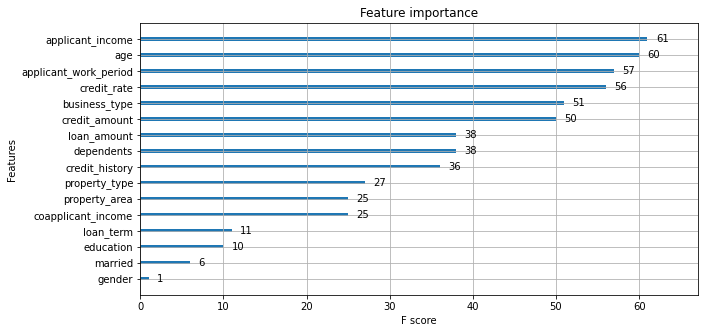

In [27]:
import xgboost
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 10, 5
xgboost.plot_importance(model)

수입(applicant income) > 나이(age) > 대출 신청자 근무 경력(applicant work period) > 신용등급(credit rate) 



최종 학력(education) > 기혼 유무(married) > 성별(gender)

피처 중요도는 음의 영향력을 표시하지 않는다.

In [30]:
!pip install shap

     |████████████████████████████████| 356 kB 4.9 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491653 sha256=9ab3ba2e0ed56e66e6a8c83dbc8e56b1ab7ddc836de013330a8c40e7a3ac6957
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [34]:
import shap

idx = 13

x_train.iloc[idx, :]

gender                      1.0
age                        30.0
married                     1.0
dependents                  0.0
education                   1.0
self_employed               0.0
business_type              74.0
applicant_income         1809.0
applicant_work_period      35.0
coapplicant_income       1868.0
credit_history              1.0
credit_amount            3212.0
property_area               1.0
property_type               1.0
credit_rate                 3.0
loan_amount              2520.0
loan_term                  30.0
Name: 498, dtype: float64

In [35]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, 
                shap_values[idx,:], 
                x_train.iloc[idx,:])

대출 승인

플러스 : 신용등급(3), 나이(30), 대출금액(2520), 업종(74: 사업시설관리, 조경 서비스업)

마이너스 : 연봉(1809)

In [32]:
idx = 15

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, 
                shap_values[idx,:], 
                x_train.iloc[idx,:])

대출 거부

플러스 : 배우자 연봉(7250)

마이너스 : 신용등급(7), 대출내역X, 나이(60)

In [38]:
# visualize the training set predictions
shap.initjs() #코랩에선 이거 써줘야함
shap.force_plot(explainer.expected_value, shap_values, x_train)

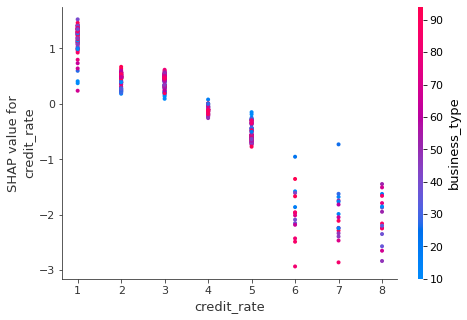

In [40]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("credit_rate", shap_values, x_train)

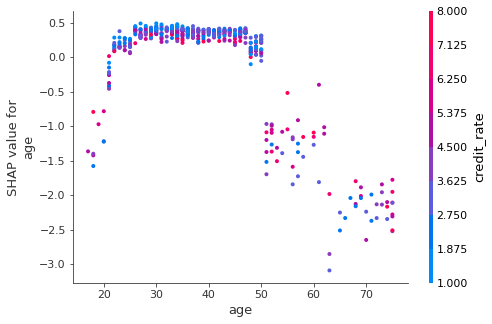

In [41]:
shap.dependence_plot("age", shap_values, x_train)

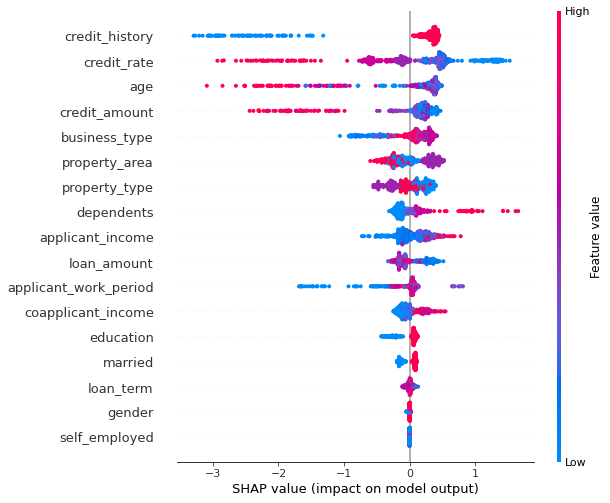

In [42]:
# summarize the effects of all the features
shap.summary_plot(shap_values, x_train)

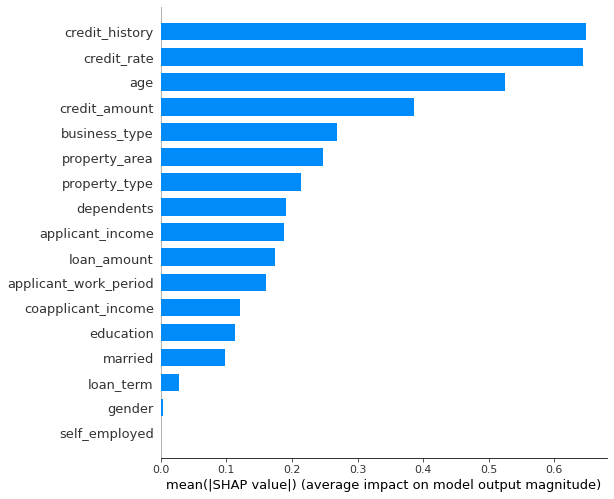

In [43]:
shap.summary_plot(shap_values, x_train, plot_type="bar")

### XAI로 모델을 파악하기

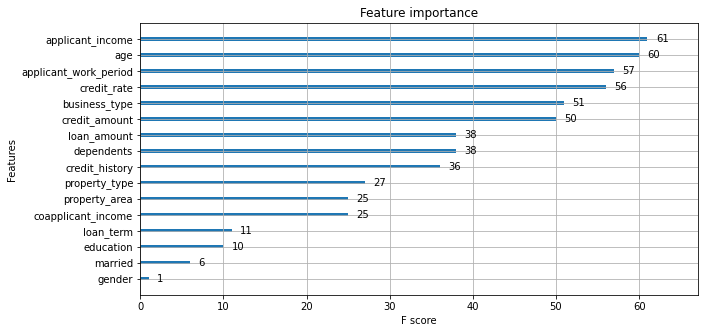

In [44]:
xgboost.plot_importance(model)

피처 중요도 : 수입 중요

SHAP : 수입 중요도 높지 않음

### XAI로 모델 개선 근거 마련하기 

In [45]:
loan_data = loan_data.drop(columns='education')

X = loan_data.loc[:, 'gender':'loan_term']
y = loan_data.loc[:, 'loan_status']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=20)

model = XGBClassifier(
    booster = 'gbtree',
    objective='binary:logistic',
    n_estimators=300,
    reg_alpha=0.7,
    reg_lambda=0.5,
    max_depth=4
)

model.fit(x_train, y_train)
calculate_accuracy(model, x_test, y_test)

Accuracy: 85.37%


0.8536585365853658

### +

In [ ]:
loan_data = loan_data.drop(columns='gender')
loan_data = loan_data.drop(columns='married')
loan_data = loan_data.drop(columns='loan_term')

X = loan_data.loc[:, 'age':'loan_amount']
y = loan_data.loc[:, 'loan_status']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=20)

In [59]:
model = XGBClassifier(
    booster = 'gbtree',
    objective='binary:logistic',
    n_estimators=300,
    reg_alpha=0.7,
    reg_lambda=0.5,
    max_depth=5
)

model.fit(x_train, y_train)
calculate_accuracy(model, x_test, y_test)

Accuracy: 86.99%


0.8699186991869918

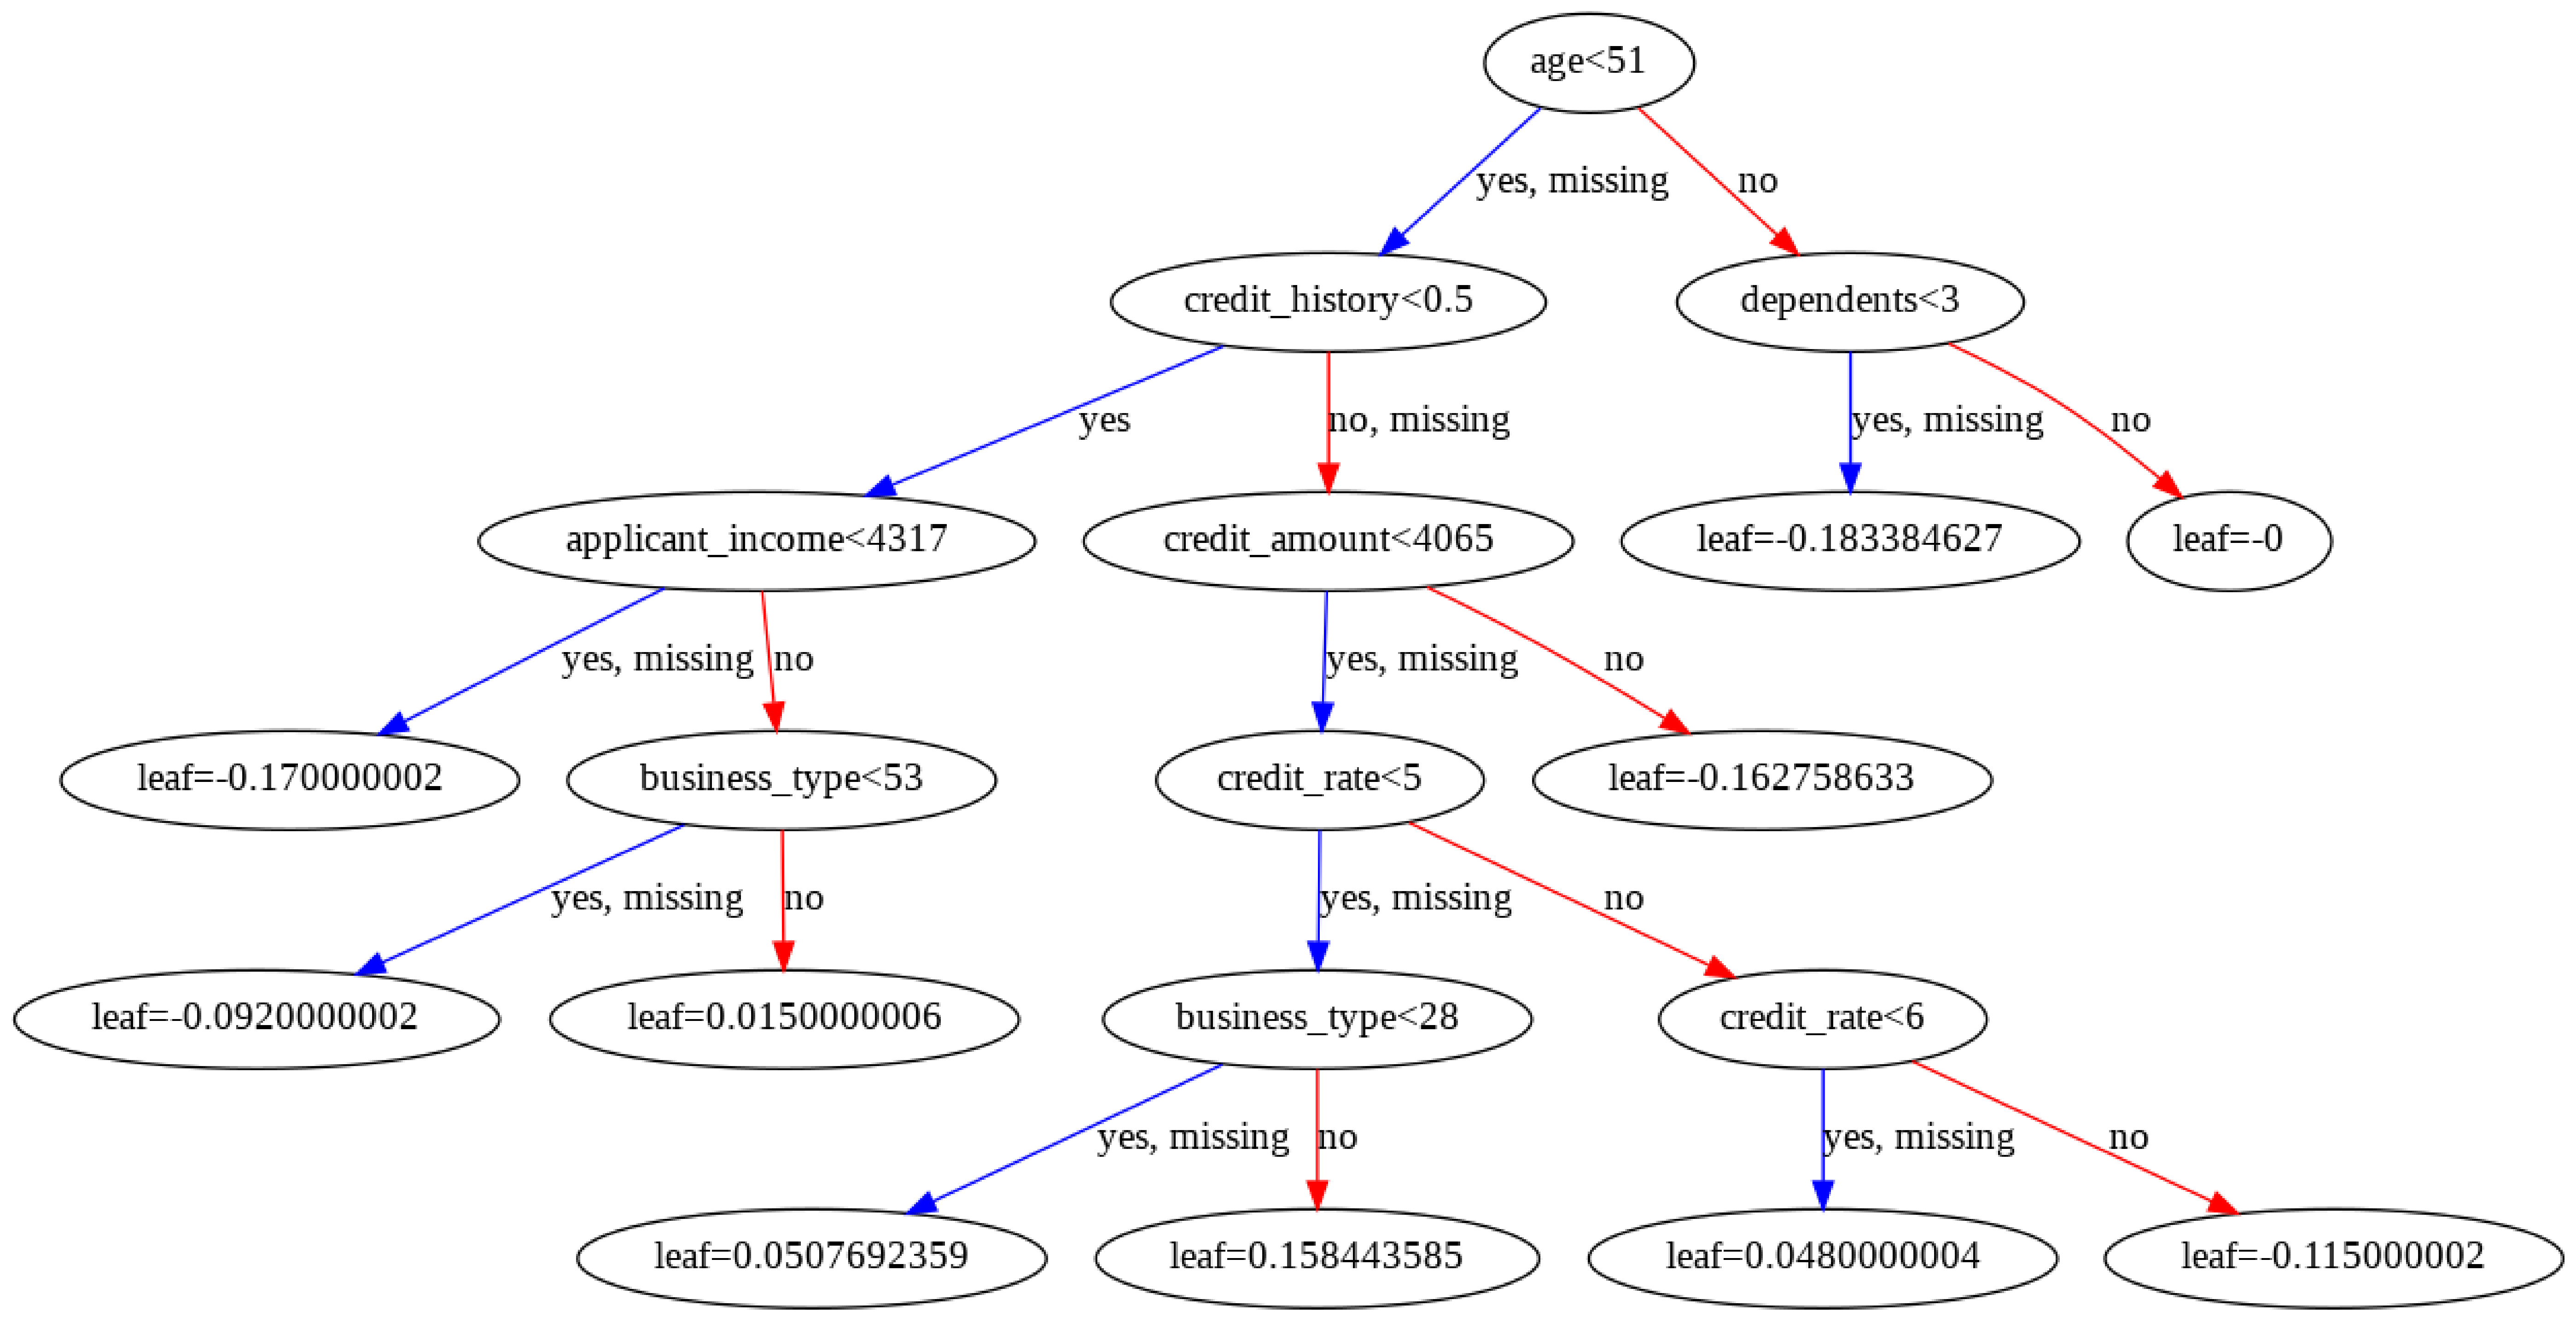

In [60]:
%matplotlib inline
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

import matplotlib.pyplot as plt

from xgboost import plot_tree
from matplotlib.pylab import rcParams

##set up the parameters
rcParams['figure.figsize'] = 100,200

plot_tree(model)
plt.show()